# 2D IR Spectral Diffusion Analysis Script v.0 

#### by Sebastian Gorgon (github.io/sebgorgon) of ULTRA Central Laser Facility

This is a walkthrough aiming to help in using the .py version of the program for conducting actual fittings.

In summary, each population time dataset is read, cropped to the selected region, and either a single 2D Gaussian fitted to the positive or negative peak, or a linear combination of two 2D Gaussians with the same spreads and angles fitted to the peak pair at once.

The bulk of the code is hidden but can be shown by clicking "Show code" below.

In [156]:
### SET UP OF ENVIRONMENT ###

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize as opt
import math
import os
from IPython.display import HTML



### SET UP OF GENERAL DATA PRE-PROCESSING ###

def df_seperate(df):
    
    """Seperate dataframe into 1D lists of x and y values, and a 2D matrix of z values"""

    x1d = np.array(df[df.columns[0]])[1:]  
    df = df.drop(df.columns[0], axis=1)
    y1d = np.array(df)[0,:]  
    z2d = np.array(df)[1:,:]

    return x1d, y1d, z2d

def df_to_xyz(df):
    
    """Convert dataframe to 1D arrays of XYZ with one-to-one correspondence - for fitting data"""
    
    df = np.array(df)
    X, Y, Z = [], [], []
    for i, y in enumerate(df[0][1:], 1):
        for z in df[1:]:
            X.append(z[0])
            Y.append(y)
            Z.append(z[i])
    return np.vstack((X,Y,Z))

def df_join(x, y, z):    
    
    """Creates dataframe from 1D lists of x and y values, and a 2D matrix of z values"""
    
    combmap = np.insert(z, 0, x, axis=1) 
    y = np.insert(y, 0, 0)
    combmap = np.insert(combmap, 0, y, axis=0)
    return pd.DataFrame(combmap)
    
def val_to_index(val, array):
    
    """Returns index of number inside the array that is closest to set value"""
    
    return np.abs(array-val).argmin()   

def crop_df(df, xrange, yrange):

    """Crops the dataset to selected region"""
    
    x1d, y1d, z2d = df_seperate(df)
    x1d = x1d[:int(len(x1d)/2)]
    xlimits = (val_to_index(xrange[0], x1d), val_to_index(xrange[1], x1d))
    ylimits = (val_to_index(yrange[0], y1d), val_to_index(yrange[1], y1d))

    x1d = x1d[xlimits[0]:xlimits[1]+1]    
    y1d = y1d[ylimits[0]:ylimits[1]+1]
    z2d = z2d[xlimits[0]:xlimits[1]+1,ylimits[0]:ylimits[1]+1]
    return df_join(x1d, y1d, z2d)

def contour_plot(df, zlim=50):
    
    """Generates a 2D plot of a dataset"""
    
    x1d, y1d, z2d = df_seperate(df)
    fig= plt.figure()
    plt.contourf(x1d, y1d, z2d.transpose(), zlim, extend='both', cmap='coolwarm')
    plt.colorbar()
    plt.xlabel('Probe / cm-1')
    plt.ylabel('Pump / cm-1')
    fig.patch.set_facecolor('w')
    return

def display_dataset(direct):
    
    """Displays first frame of dataset so that x and y limits can be set"""
    
    for filename in os.listdir(direct):
        if filename.endswith(".csv"):
             frame = str(os.path.join(direct, filename))
    dataset = pd.read_csv(frame, header=None, delimiter='\t') 
    return contour_plot(np.abs(dataset))



### DEFINES 2 TYPES OF 2D GAUSSIAN FUNCTIONS ###

def uni_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6]
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    xo, yo = float(xo), float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)

    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def bi_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude1, amplitude2, xo1, xo2, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8]    
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude1*np.exp( - (a*((x-xo1)**2) + 2*b*(x-xo1)*(y-yo) + c*((y-yo)**2))) \
    + amplitude2*np.exp( - (a*((x-xo2)**2) + 2*b*(x-xo2)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()



### SET UP OF FITING FUNCTIONS ###

def peaksign(peakselect, data, p0):

    """Splices data to have only positive or only negative datapoints in array."""
    
    func = uni_gauss


    if peakselect == 1:
        newz = [0 if j < 0 else j for j in data]
        npnewz = np.array(newz)
        p0 = np.delete(p0, [1,3])
        
    elif peakselect == -1:
        newz = [0 if j > 0 else j for j in data]
        npnewz = np.array(newz)
        npnewz = -npnewz                       
        p0 = np.delete(p0, [1,2])

    elif peakselect == 0:
        npnewz = np.abs(data)
        func = bi_gauss
        
    return npnewz, p0, func

def fit_calc(popt, pcov, time, func):
    
    std = np.sqrt(np.diag(pcov))
    
    if func is uni_gauss:
        popt = np.insert(popt, [1,2], [popt[0], popt[1]])
        std = np.insert(std, [1,2], [std[0], std[1]])

    sx, sy, ex, ey = abs(popt[5]), abs(popt[6]) ,std[5],std[6]
    if sx < sy:
        sx, sy, ex, ey = sy, sx, ey, ex
    
    elipt = abs((sy)**2 - (sx)**2)/((sx)**2 + (sy)**2)
    elipterr = ((((2*sx - sy**2)/(2*sx + sy**2))*ex)**2 + (((sx**2 - 2*sy)/(sx**2 + 2*sy))*ey)**2)**0.5

    theta = popt[7] - (popt[7] // np.pi) * np.pi
    if theta > 0.5 * np.pi:
        theta = np.pi - theta
    if theta < 0.25 * np.pi:
        theta = 0.5 * np.pi - theta
    thetaerr = std[7]                     

    igrad = 1 / math.tan(theta)
    igraderr = ((np.cos(theta)) ** 0.5) * thetaerr                     

    arrres = (time, popt[0], popt[1], popt[2], popt[3], popt[4], sx, ex, sy, ey, elipt,\
              elipterr, theta, thetaerr, igrad, igraderr)
    cols = ['time','Ampl_1','Ampl_2','x0_1','x0_2','y_0', 'sigma_x', 'sigma_x_err','sigma_y',\
            'sigma_y_err', 'elipt','elipt_err', 'theta', 'theta_err', 'igrad', 'igrad_err']

    dfres = pd.DataFrame(columns=cols)
    dfres.loc[0] = np.array(arrres)
    dfres = dfres.set_index('time')
    return dfres

def fit_frame(xyzdat, peakselect, time, p0):

    """Orders processing of a single timedelay frame."""

    xy = np.append(xyzdat[0], xyzdat[1])
    
    fiterrbool = False
    
    try:
        data, p0, func = peaksign(peakselect, xyzdat[2], p0)
        popt, pcov = opt.curve_fit(f=func, xdata=xy, ydata=data, p0=p0, method='dogbox', maxfev=1000)
        fitraveled = func(xy, popt)

        resrow = fit_calc(popt, pcov, time, func)
        
        diff = data - fitraveled
        qfit = sum((abs(diff))/popt[0])                                         ## FIX QFIT PARAMETER
    
    except RuntimeError:
        fiterrbool = True
        print("Error - curve_fit failed")
    
    datforfig = xyzdat, fitraveled, diff

    return datforfig, resrow

def plot_frame(df, datforfig):

    xyzdat, fitraveled, diff = datforfig
    extx = (np.min(xyzdat[0]), np.max(xyzdat[0]), np.min(xyzdat[1]), np.max(xyzdat[1]))
    
    contour_plot(df) 
    plt.tricontour(xyzdat[0], xyzdat[1], fitraveled, 5, extent=extx, linewidths=1, colors='k')
    plt.show()
    return
    
def plot_diff(df, datforfig):

    xyzdat, fitraveled, diff = datforfig
    x1d, y1d, z2draw = df_seperate(df)

    z2d = np.reshape(diff, (len(y1d), len(x1d)))
    diffdf = df_join(x1d, y1d, z2d.transpose())
    
    contour_plot(diffdf)
    plt.show()
    return

def fit_dataset(direct, peakselect, p0, xrange, yrange, showfig=False):
    
    """Fits the entire dataset"""
    
    paths = []
    combres = pd.DataFrame()

    for filename in os.listdir(direct):
        if filename.endswith(".csv"):
            paths.append(str(os.path.join(direct, filename)))

    for i in range(len(paths)):
        frame = paths[i]
        time = float(frame[(frame.find('_')+1):frame.find('ps')])
                                    
        dffr = pd.read_csv(frame, header=None, delimiter='\t')
        dfframe = crop_df(dffr, xrange, yrange) 

        xyzdat = df_to_xyz(dfframe)
        datforfig, resrow = fit_frame(xyzdat, peakselect, time, p0)
        
        combres = pd.concat([combres, resrow])                                
        
        if showfig is True:
            print(str(time))  
            plot_frame(dfframe,datforfig) 

    combres = combres.sort_index(axis=0)
    return combres

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show code</a>.''')

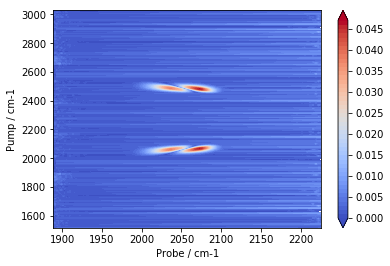

In [191]:
target = 'C:/PYTHONALL/023s'
display_dataset(target)

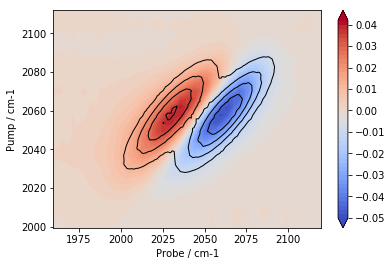

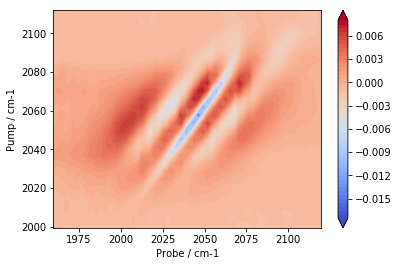

                    Ampl_1               Ampl_2                x0_1  \
time                                                                  
test  0.040571406717249625  0.04835836657340462  2029.2980698449173   

                  x0_2                 y_0             sigma_x  \
time                                                             
test  2062.35977929797  2057.9526053469076  21.840426762267676   

              sigma_x_err            sigma_y          sigma_y_err  \
time                                                                
test  0.16887162796962873  6.750878192821422  0.04740495827393047   

                   elipt           elipt_err               theta  \
time                                                               
test  0.8255789403181757  0.0449382323637246  0.7950862707856445   

                  theta_err               igrad              igrad_err  
time                                                                    
test  0.0037488119615703423 

In [153]:
"""Single frame for testing"""

dffr = pd.read_csv('C:/PYTHONALL/023s/LIFE023 22C_0.000ps_2DIR.csv', header=None, delimiter='\t')
dfframe = crop_df(dffr, xrange=(1960, 2120), yrange=(2000, 2110))

peakselect = 0
p0 = (0.20,0.15,2040,2060,2065,20,5,0,0)
time = 'test'

xyzdat = df_to_xyz(dfframe)
datforfig, resrow = fit_frame(xyzdat, peakselect, time, p0)
plot_frame(dfframe,datforfig)
plot_diff(dfframe,datforfig)
print(resrow)

0.0


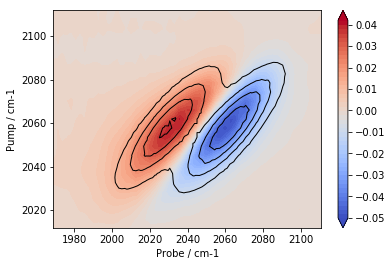

10.0


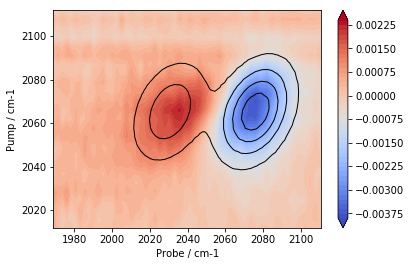

3.0


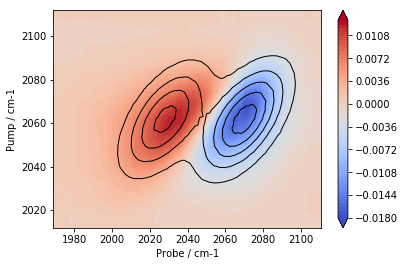

,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,
0.0,0.040488,0.048345,2029.367033,2062.334106,2057.959733,21.673635,0.190069,6.690725,0.052980,0.825987,0.050138,0.794978,0.004164,0.981022,0.003485
3.0,0.012551,0.016168,2028.012745,2070.056797,2061.771576,18.132306,0.181268,9.507937,0.087437,0.568679,0.109849,0.855712,0.009345,0.868408,0.007567
10.0,0.002074,0.003614,2030.626632,2075.939405,2065.313193,15.042593,0.171057,10.403955,0.109371,0.352854,0.132714,1.003934,0.019538,0.636551,0.014317


In [176]:
p0 = (0.20,0.15,2039,2060,2065,20,5,0,0)
peakselect = +0
xrange = (1960, 2120)
yrange = (2000, 2110)
showfig = True

fit_dataset(target, peakselect, p0, xrange, yrange, showfig)